In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    #print(f'SHAPE: {labels.shape}')
    #print(f'FSHAPE: {labels.flatten().shape}')
    for label in labels.flatten():
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [3]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [4]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
    #print(f'index: {column_index}, DATA: {np.array(data.take([column_index], axis=1))}, t: {t}')
    #left = np.where(np.array(data.take([column_index], axis=1)) <= t)
    #right = np.where(np.array(data.take([column_index], axis=1)) > t)
    
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [5]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        return self.targets.mean()

In [7]:
def mse(targets):
    return np.mean((targets - targets.mean())**2)

In [8]:
# Нахождение наилучшего разбиения

def find_best_split(data, targets):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 10

    root_mse = mse(targets)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    print(data.shape)
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения PANDAS
        t_values = np.unique(np.array(data)[:, index])
        #t_values = data.take([index], axis=1)
        for t in t_values:
            true_data, false_data, true_targets, false_targets = split(data, targets, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_targets, false_targets, root_mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [9]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, target):

    gain, t, index = find_best_split(data, target)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, target)

    true_data, false_data, true_target, false_target = split(data, target, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_target)
    false_branch = build_tree(false_data, false_target)

    node = Node(index, t, true_branch, false_branch)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return node

In [10]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
def min_max_scale(X):
    return (X - X.min()) / (X.max() - X.min())

In [14]:
def reverse_min_max(X, g):
    return (g * (X.max() - X.min())) + X.min()

In [15]:
from sklearn.metrics import r2_score

In [16]:
df_raw = pd.read_csv('./data/train.csv', sep=',')

features = ['age', 'years_of_experience', 'lesson_price', 'qualification', 'physics', 'chemistry', 'biology', 'english', 'geography', 'history'] 
target = ['mean_exam_points']
df_raw = df_raw[features + target]
df_raw

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,61
1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,76
2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53
3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,54
4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57
...,...,...,...,...,...,...,...,...,...,...,...
9995,44.0,0.0,1700.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,83
9996,51.0,0.0,1700.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,58
9997,34.0,1.0,1250.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,62
9998,33.0,3.0,1100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56


In [17]:
df_num_features = df_raw.select_dtypes(include=['float64', 'int64'])

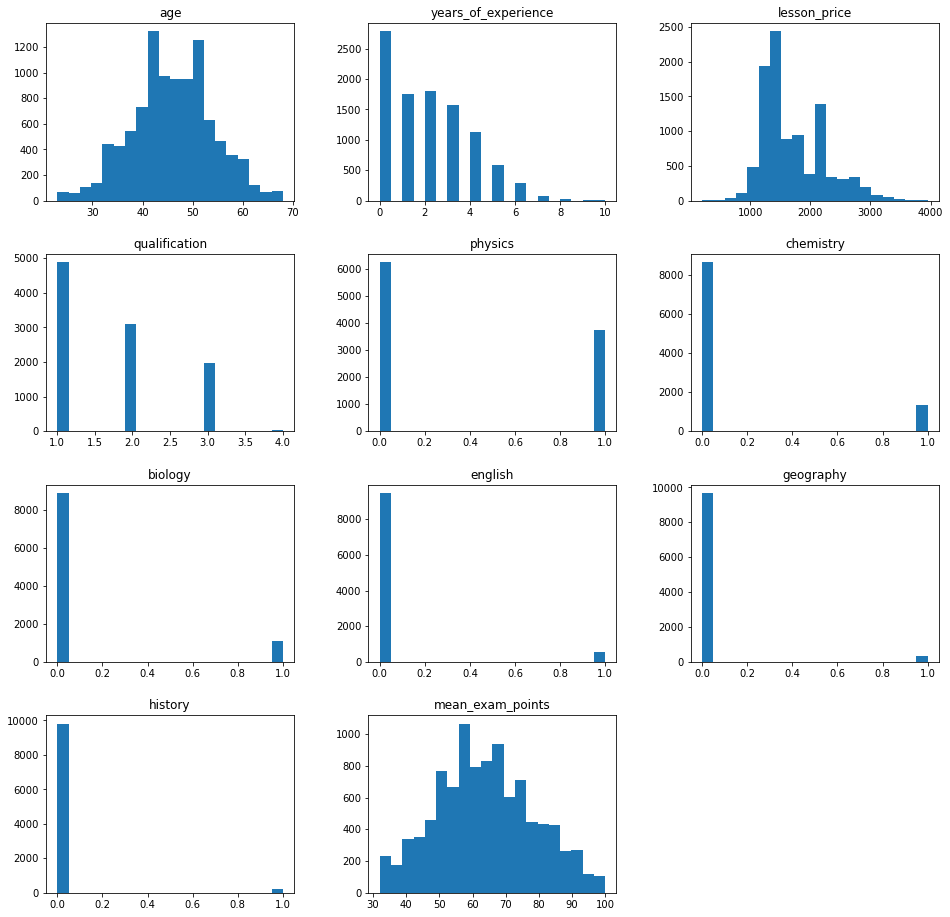

In [18]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [19]:
X = np.array(df_raw[features].copy())
Y = np.array(df_raw[target].copy())
Y.shape[1]

1

In [20]:
#df_np = np.array(df_raw[features + target])
#df_np

In [21]:
X_norm = X.copy().astype(np.float64)
Y_norm = Y.copy().astype(np.float64)
for i in range(X.shape[1]):
    X_norm[:, i] = min_max_scale(X_norm[:, i]) 
Y_norm = min_max_scale(Y)

In [22]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X_norm.T @ X_norm

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(7892.147230842015, array([-0.5535957 , -0.2249704 , -0.44038834, -0.29575382, -0.55850735,
       -0.16550581, -0.1301731 , -0.05959989, -0.03519489, -0.02119943]))
(1885.168161551913, array([ 0.31966724,  0.15192495,  0.28807902,  0.27370042, -0.82517461,
        0.14455227,  0.11574722,  0.03365567,  0.01967338,  0.01022575]))
(1133.0880483306498, array([-0.08961942, -0.06171439, -0.11686879, -0.17435425,  0.01985815,
        0.97064876, -0.03748891,  0.00250393, -0.00927936, -0.00712831]))
(972.408800682959, array([-0.04100471, -0.05095837, -0.09956973, -0.18398473,  0.01343542,
       -0.0147984 ,  0.97527983,  0.01330598, -0.01362803,  0.0049313 ]))
(630.6127816095423, array([-0.61560381, -0.02872814,  0.14682138,  0.73564028,  0.07847017,
        0.09434111,  0.12835977, -0.15398898, -0.04190876, -0.02192037]))
(506.43356430441105, array([-0.14289008, -0.03586617,  0.00633941,  0.08302467,  0.0060026 ,
       -0.0029

In [23]:
# Оценим долю дисперсии, которая описывается найденными компонентами.
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[56.75139291598954, 13.555996349238395, 8.14788715394553, 6.992463813506049, 4.5346535866830235, 3.6416971646660885, 2.2394741397974283, 2.048243802739851, 1.3658785678935055, 0.7223125055405878]
Кумулятивная доля дисперсии по компонентам 
[ 56.75139292  70.30738927  78.45527642  85.44774023  89.98239382
  93.62409098  95.86356512  97.91180893  99.27768749 100.        ]


In [24]:
# Сформируем вектор весов из собственных векторов, соответствующих первым пяти главным компонентам
W = np.hstack([eig_pairs[i][1].reshape(10,1) for i in range(5)])

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[-0.5535957   0.31966724 -0.08961942 -0.04100471 -0.61560381]
 [-0.2249704   0.15192495 -0.06171439 -0.05095837 -0.02872814]
 [-0.44038834  0.28807902 -0.11686879 -0.09956973  0.14682138]
 [-0.29575382  0.27370042 -0.17435425 -0.18398473  0.73564028]
 [-0.55850735 -0.82517461  0.01985815  0.01343542  0.07847017]
 [-0.16550581  0.14455227  0.97064876 -0.0147984   0.09434111]
 [-0.1301731   0.11574722 -0.03748891  0.97527983  0.12835977]
 [-0.05959989  0.03365567  0.00250393  0.01330598 -0.15398898]
 [-0.03519489  0.01967338 -0.00927936 -0.01362803 -0.04190876]
 [-0.02119943  0.01022575 -0.00712831  0.0049313  -0.02192037]]


In [25]:
# Сформируем новую матрицу "объекты-признаки"
Z = X_norm.dot(W)

In [26]:
train_data_regr, test_data_regr, train_target_regr, test_target_regr = train_test_split(Z,  Y_norm, 
                                                                                    test_size=0.3,
                                                                                    random_state=1)

In [27]:
train_data_regr

array([[-1.07928982, -0.4766352 , -0.1248383 , -0.10594503,  0.10881046],
       [-0.4295096 ,  0.25581373, -0.06892522, -0.03105389, -0.40407601],
       [-0.59530909,  0.3520031 , -0.09637353, -0.04422729, -0.57995949],
       ...,
       [-0.73316588,  0.51043934, -0.22792146, -0.19895712,  0.24236718],
       [-0.55863814,  0.33429003, -0.10623542, -0.06458763, -0.40054471],
       [-1.34731201, -0.28305774, -0.21646278, -0.18875018,  0.25047931]])

In [28]:
my_tree = build_tree(train_data_regr, train_target_regr)
print_tree(my_tree)

(7000, 5)
Прогноз: 0.4684579831932773


In [29]:
train_answers = predict(train_data_regr, my_tree)
train_r2 = r2_score(train_target_regr, train_answers)
print(train_r2)

answers = predict(test_data_regr, my_tree)
test_r2 = r2_score(test_target_regr, answers)
print(test_r2)

0.0
-0.0007342089009323427


In [30]:
#answers